In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [3]:
# import zipfile
# corpus_zip = zipfile.ZipFile('/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.zip', 'r')
# recipe_str = corpus_zip.read(corpus_zip.namelist()[0])
# recipe = json.loads(recipe_str)

In [4]:
filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.json"
op_file_path = "data/ing_density.csv"
with open(filepath) as json_data:
    recipe = json.load(json_data)

In [5]:
filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer2.json"
with open(filepath) as json_data:
    recipe_images = json.load(json_data)

In [6]:
unit_abbreviation = { 'tbsp' : ["tablespoon"],
                      'tsp' : ['teaspoon'],
                     'ml' : ['milliliter'],
                     'cup' : ['cups','cup'],
                     'oz' : ['ounces','oz', 'ounce']
    
}

In [7]:
# # loading recipe
# dict_ingredients= recipe_load(n=2, recipe=recipe)
# df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
# df_combined_ing

In [8]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [9]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [10]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('data/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [18]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
print(i)
recipe_id, dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(float)


qty = Qty_normal_map(unit_abbreviation = unit_abbreviation, op_file_path= op_file_path)
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = df_combined_ing.groupby(by=['ingredient', 'normalized_unit'], 
                                               as_index = False)\
                                      .agg({'quantity': 'sum', 'Volume_in_ml': 'sum'})
#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


897561
Recipe: Garlic Scalloped Potatoes
ID: df1385d09b


/Users/mvellera/USF/Intersession/Practicum (Target)/Code/qty_mapping.py:54: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [19]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == recipe_id:
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

<Figure size 1440x720 with 0 Axes>

In [20]:
recipe[i]

{'ingredients': [{'text': '3 lb. baking potatoes (about 6), peeled, very thinly sliced Safeway 2 pkg For $5.00 thru 02/09'},
  {'text': '1 tub (8 oz.) PHILADELPHIA Chive & Onion Cream Cheese Spread'},
  {'text': '1 cup milk'},
  {'text': '1/2 tsp. garlic powder'},
  {'text': '1/8 tsp. ground black pepper'},
  {'text': '2/3 cup KRAFT Shredded Parmesan Cheese'}],
 'url': 'http://www.kraftrecipes.com/recipes/garlic-scalloped-potatoes-161643.aspx',
 'partition': 'train',
 'title': 'Garlic Scalloped Potatoes',
 'id': 'df1385d09b',
 'instructions': [{'text': 'Heat oven to 350 degrees F.'},
  {'text': 'Cook potatoes in boiling water in saucepan 25 min.'},
  {'text': 'or just until tender; drain.'},
  {'text': 'Cool.'},
  {'text': 'Peel and slice potatoes.'},
  {'text': 'Whisk cream cheese spread, milk, garlic powder and pepper until blended.'},
  {'text': 'Layer half each of the potatoes, cream cheese mixture and Parmesan in shallow 2-qt.'},
  {'text': 'casserole sprayed with cooking spray; r

In [21]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,KRAFT Shredded Parmesan Cheese,cup,0.666667,150.0,"(1.0, 5.0, tbsp)",1.0,5.0,tbsp
1,garlic powder,tsp,0.500000,0.0,"(1.0, 9.7, tbsp)",1.0,9.7,tbsp
2,ground black pepper,tsp,0.125000,0.0,"(1.0, 6.9, tbsp ground)",1.0,6.9,tbsp ground
3,lb baking potatoes,count,3.000000,0.0,"(1.0, 130.0, cup)",1.0,130.0,cup
4,milk,cup,1.000000,225.0,"(1.0, 244.0, cup)",1.0,244.0,cup
5,tub PHILADELPHIA Chive & Onion Cream Cheese S...,count,1.000000,0.0,"(1.0, 224.0, cup)",1.0,224.0,cup


In [22]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients, 3)

rslt_df = group10[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value', 'package_weight_unit_of_measure','package_weight']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group10['tcin'].isin(ranked_match[i])] 
    ing = recipe_ingredients[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'ingredient']=ing
                break
       
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

#matching target database with recipe 
join_df = pd.merge(final_rslt_df, final_df, 
                   how = 'left', on = 'ingredient')

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price'])
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']]

[1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 0, 0]


/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


garlic powder
[77585075 77585074 13460642]


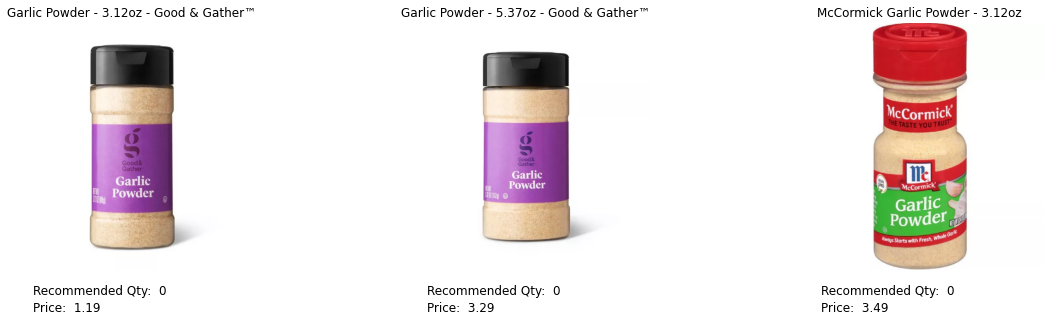

ground black pepper
[47984499 13460842 13476785]


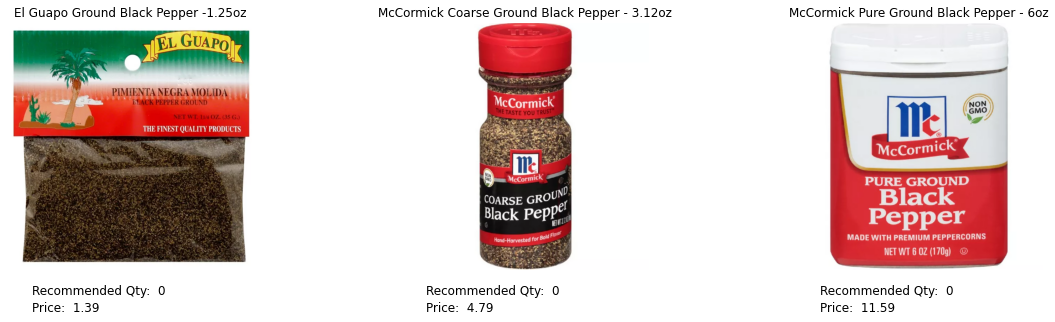

kraft shredded parmesan cheese
[12958583 82291178 14712433]


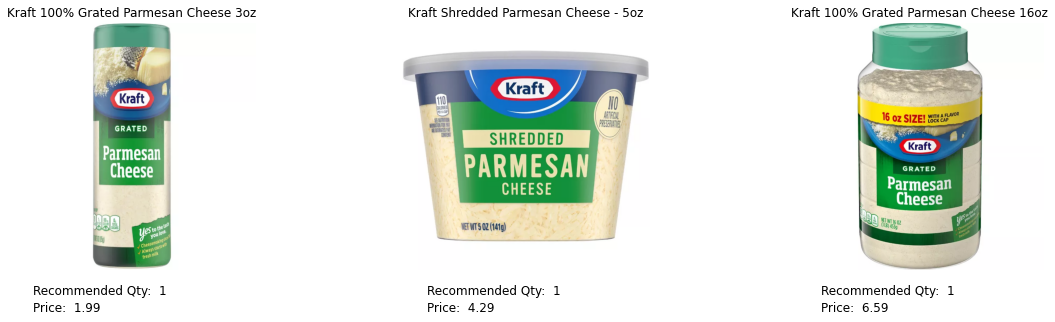

lb baking potatoes
[77788567 14993270 15028482]


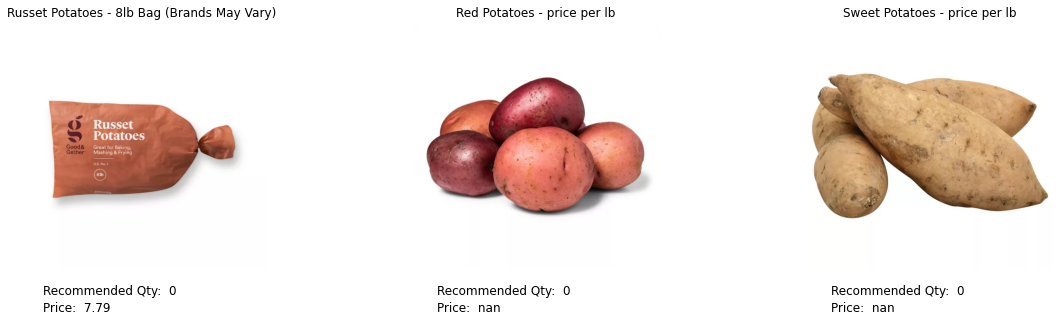

milk
[13276127 13276128 13276131]


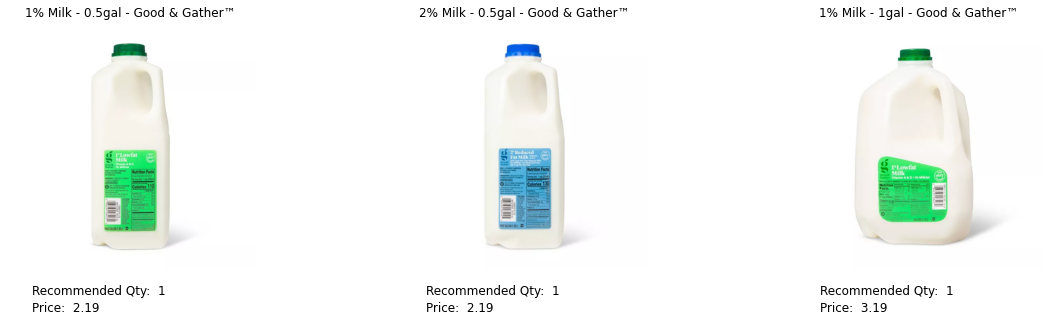

tub philadelphia chive onion cream cheese spread
[79694584 12958526 14734260]


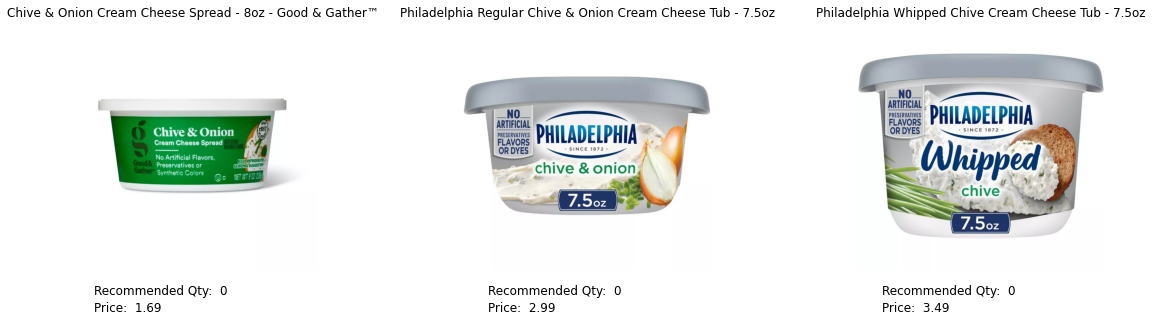

In [23]:
dp.display_products_df(display_df, 3)